In [1]:
import xarray as xr
import numpy as np
from xgcm.grid import Grid
from dask.diagnostics import ProgressBar
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

In [2]:
XG=np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/XG.data', dtype='>f4')
YG=np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/YG.data', dtype='>f4')
YC=np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/YC.data', dtype='>f4')
YC = YC.reshape(2160,2160)
YG = YG.reshape(2160,2160)
DYG=np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYG.data', dtype='>f4')
DXG=np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXG.data', dtype='>f4')
DXG = DXG.reshape(2160,2160)
DYG = DYG.reshape(2160,2160)
DYC=np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DYC.data', dtype='>f4')
DXC=np.fromfile('/swot/SUM01/spencer/swot_agulhas_test/DXC.data', dtype='>f4')
DXC = DXC.reshape(2160,2160)
DYC = DYC.reshape(2160,2160)

In [46]:
uvel_merged = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/uvel.zarr')
vvel_merged = xr.open_zarr('/swot/SUM01/spencer/swot_agulhas_surf/vvel.zarr')
eta_merged = xr.open_zarr('/swot/SUM02/spencer/swot_agulhas_surf/eta.zarr')

uvel_merged_l = uvel_merged.isel(time=slice(41-20,41+33+20)).sel(k=8)

vvel_merged_l = vvel_merged.isel(time=slice(41-20,41+33+20)).sel(k=8)

eta_merged_l = eta_merged.isel(time=slice(41-20,41+33+20))

uvel_merged = uvel_merged.isel(time=slice(41,41+33)).sel(k=8)

vvel_merged = vvel_merged.isel(time=slice(41,41+33)).sel(k=8)

eta_merged = eta_merged.isel(time=slice(41,41+33))



uvel_merged['time'] = uvel_merged['time']/ np.timedelta64(1, 's')
vvel_merged['time'] = vvel_merged['time']/ np.timedelta64(1, 's')
eta_merged['time'] = eta_merged['time']/ np.timedelta64(1, 's')
uvel_merged_l['time'] = uvel_merged_l['time']/ np.timedelta64(1, 's')
vvel_merged_l['time'] = vvel_merged_l['time']/ np.timedelta64(1, 's')
eta_merged_l['time'] = eta_merged_l['time']/ np.timedelta64(1, 's')
grid = Grid(uvel_merged, coords={'X': {'center': 'i', 'left': 'i_g'}, 'Y': {'center': 'j', 'left': 'j_g'}})

In [47]:
def lanczos(x, a):
    return np.sinc(x/a)

In [48]:
window_width=20
weight = xr.DataArray(lanczos(np.arange(-window_width/2,window_width/2), window_width/2), dims=['window'])
windowed_u = uvel_merged_l.U.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
windowed_v = vvel_merged_l.V.chunk({'time':-1}).rolling(time=window_width, center=True).construct('window').dot(weight)/np.sum(weight)
u_filtered = windowed_u.sel(time=uvel_merged.time.values)
v_filtered = windowed_v.sel(time=vvel_merged.time.values)

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/xarray/core/indexing.py:1369: PerformanceWarning: Slicing is producing a large chunk. To accept the large
chunk and silence this warning, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': False}):
    ...     array[indexer]

To avoid creating the large chunks, set the option
    >>> with dask.config.set(**{'array.slicing.split_large_chunks': True}):
    ...     array[indexer]
  return self.array[key]


In [49]:
DYG_g = xr.DataArray(DYG, dims=["j", "i_g"],coords=dict(j=(["j"], uvel_merged.j),i_g=(["i_g"], uvel_merged.i_g)))
DXG_g = xr.DataArray(DXG, dims=["j_g", "i"],coords=dict(j=(["j_g"], vvel_merged.j_g),i=(["i"], vvel_merged.i)))

In [50]:
YG_g = xr.DataArray(YG, dims=["j_g", "i"],coords=dict(j=(["j_g"], uvel_merged.j),i_g=(["i"], uvel_merged.i_g)))
YC_g = xr.DataArray(YC, dims=["j", "i_g"],coords=dict(j=(["j"], uvel_merged.j),i_g=(["i_g"], uvel_merged.i_g)))

Text(0.5, 1.0, 'Eulerian unfiltered du/dt')

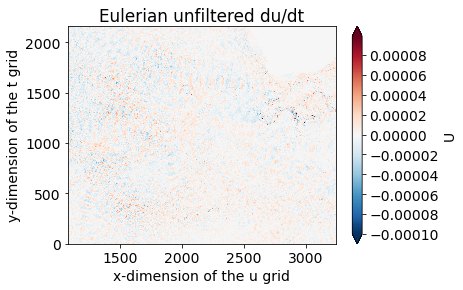

In [62]:
#centered difference differentiation
dudt = uvel_merged.U.chunk({'time':-1}).differentiate('time')
dvdt = vvel_merged.V.chunk({'time':-1}).differentiate('time')
dudt.isel(time=0).plot(levels=np.arange(-1,1,0.01)*10**-4)
plt.title('Eulerian unfiltered du/dt')

Text(0.5, 1.0, 'Eulerian filtered du/dt')

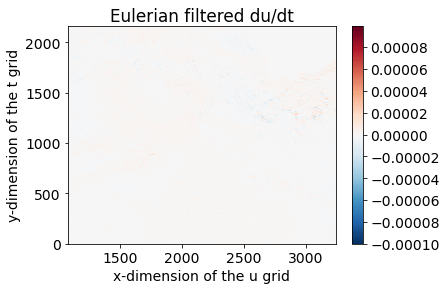

In [63]:
#centered difference differentiation
dudt_f = u_filtered.chunk({'time':-1}).differentiate('time')
dvdt_f = v_filtered.chunk({'time':-1}).differentiate('time')
dudt_f.isel(time=0).plot(levels=np.arange(-1,1,0.01)*10**-4)
plt.title('Eulerian filtered du/dt')

Text(0.5, 1.0, 'Eulerian unfiltered fv')

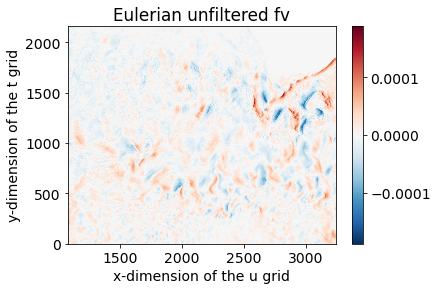

In [64]:
#calc u on v points and v on u points
fG = 2*2*np.pi/24/3600*np.sin(YG_g*np.pi/180)
fC = 2*2*np.pi/24/3600*np.sin(YC_g*np.pi/180)
fu = grid.interp(grid.interp(uvel_merged.U,'X'),'Y')*fG
fv = grid.interp(grid.interp(vvel_merged.V,'X'),'Y')*fC
fv.isel(time=0).plot()
plt.title('Eulerian unfiltered fv')

Text(0.5, 1.0, 'Eulerian unfiltered advection of u')

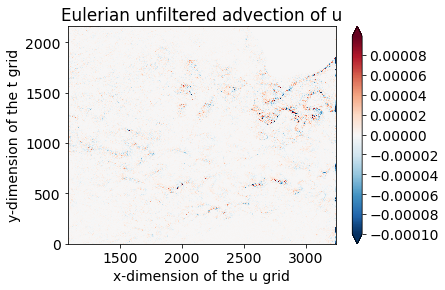

In [65]:
#calc u advection terms
uu_term = grid.diff((grid.interp(uvel_merged.U*DYG_g,'X')*grid.interp(uvel_merged.U,'X')),'X')/DXC/DYG_g #end up on u points
uv_term = grid.diff((grid.interp(vvel_merged.V*DXG_g,'X')*grid.interp(uvel_merged.U,'Y')),'Y')/DXC/DYG_g #end up on u points
(uu_term+uv_term).isel(time=0).plot(levels=np.arange(-1,1,0.01)*10**-4)
plt.title('Eulerian unfiltered advection of u')

Text(0.5, 1.0, 'Eulerian unfiltered advection of v')

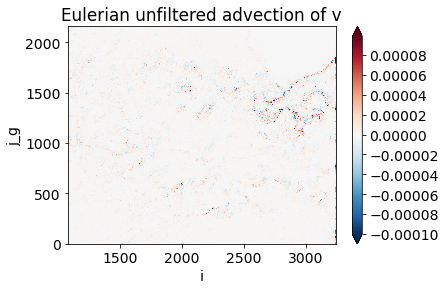

In [66]:
#calc v advection terms
vv_term = grid.diff((grid.interp(vvel_merged.V*DXG_g,'Y')*grid.interp(vvel_merged.V,'Y')),'Y')/DXG_g/DYC #end up on v points
vu_term = grid.diff((grid.interp(uvel_merged.U*DYG_g,'Y')*grid.interp(vvel_merged.V,'X')),'X')/DXG_g/DYC #end up on v points
(vu_term+vv_term).isel(time=0).plot(levels=np.arange(-1,1,0.01)*10**-4)
plt.title('Eulerian unfiltered advection of v')

Text(0.5, 1.0, 'Eulerian unfiltered dp/dx')

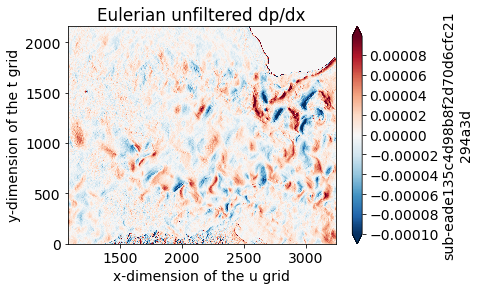

In [67]:
detadx = grid.diff(9.81*eta_merged.Eta,'X')/DXC
detady = grid.diff(9.81*eta_merged.Eta,'Y')/DYC
detadx.isel(time=0).plot(levels=np.arange(-1,1,0.01)*10**-4)
plt.title('Eulerian unfiltered dp/dx')

[########################################] | 100% Completed | 36.6s
[########################################] | 100% Completed | 14.7s
[####                                    ] | 11% Completed | 11.2s

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  1min  5.3s


Text(0.5, 1.0, 'Variance of fv explained by dp/dx')

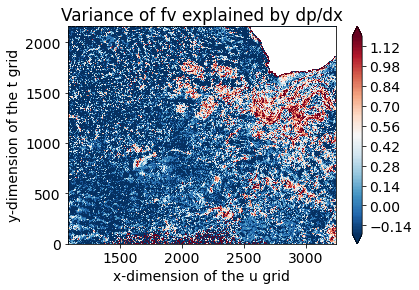

In [68]:
with ProgressBar():
    detadx_cov = ((xr.cov(detadx,fv,'time')
          )/xr.cov(fv,fv,'time')).compute()


detadx_cov.plot(levels=np.arange(-0.2,1.2,0.01))
plt.title('Variance of fv explained by dp/dx')

[########################################] | 100% Completed | 19.0s
[########################################] | 100% Completed | 14.3s
[###########                             ] | 29% Completed | 14.4s

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 50.1s
[########################################] | 100% Completed | 18.7s
[########################################] | 100% Completed | 15.0s
[##########                              ] | 26% Completed |  9.6s

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 38.3s


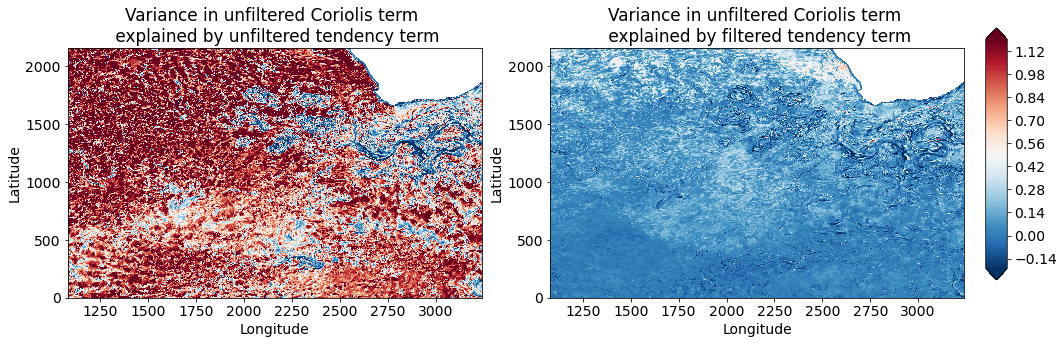

In [61]:
with ProgressBar():
    dudt_cov = (xr.cov(dudt,fv,'time'
      )/xr.cov(fv,fv,'time')).compute()
    dudt_f_cov = (xr.cov(dudt_f,fv,'time'
      )/xr.cov(fv,fv,'time')).compute()
    
plt.figure(figsize=(15,5))
plt.subplot(121)
dudt_cov.plot(levels=np.arange(-0.2,1.2,0.01),add_colorbar=False)
plt.title('Variance in unfiltered Coriolis term \n explained by unfiltered tendency term')
plt.xlabel('Longitude')
plt.ylabel('Latitude')


plt.subplot(122)
cs = dudt_f_cov.plot(levels=np.arange(-0.2,1.2,0.01),add_colorbar=False)
plt.title('Variance in unfiltered Coriolis term \n explained by filtered tendency term')
plt.xlabel('Longitude')
plt.ylabel('Latitude')

plt.tight_layout()

fig=plt.gcf()
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.2, 0.02, 0.7])
fig.colorbar(cs, cax=cbar_ax)

fig=plt.gcf()
fig.savefig('Eul_cor_tend_variance.png')

[########################################] | 100% Completed | 34.5s
[########################################] | 100% Completed | 14.5s
[#############                           ] | 33% Completed | 31.9s

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed |  1min 18.8s


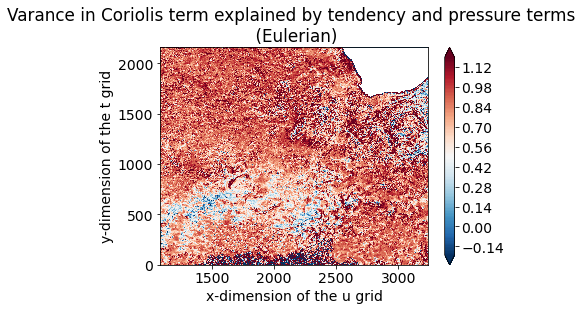

In [15]:
with ProgressBar():
    dudt_detadx_cov = (xr.cov((dudt+detadx),fv,'time'
      )/xr.cov(fv,fv,'time')).compute()
    
dudt_detadx_cov.plot(levels=np.arange(-0.2,1.2,0.01))
plt.title('Varance in Coriolis term explained by tendency and pressure terms \n (Eulerian)')

fig=plt.gcf()
fig.savefig('Eulerian_variance.png')

[########################################] | 100% Completed | 20.4s
[########################################] | 100% Completed | 24.8s
[########################################] | 100% Completed |  6.5s
[########################################] | 100% Completed |  6.4s
[########################################] | 100% Completed | 31.9s


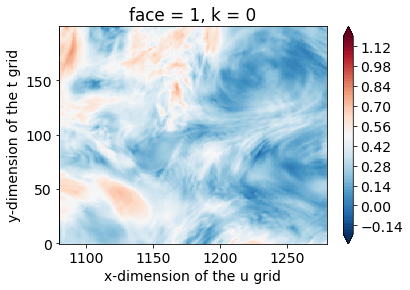

In [223]:
with ProgressBar():
    dudt_detadx_cov = (xr.cov((dudt.isel(i_g=slice(0,200),j=slice(0,200))+detadx.rolling(time=3, center=True).mean().isel(i_g=slice(0,200),j=slice(0,200))),fv.isel(i_g=slice(0,200),j=slice(0,200)),'time'
      )/xr.cov(fv.isel(i_g=slice(0,200),j=slice(0,200)),fv.isel(i_g=slice(0,200),j=slice(0,200)),'time')).compute()

dudt_detadx_cov.plot(levels=np.arange(-0.2,1.2,0.01))

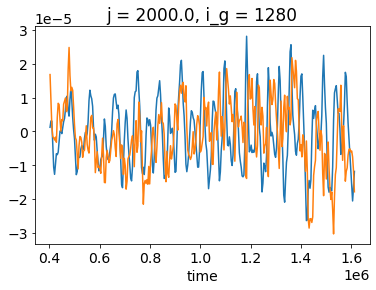

In [228]:
dudt.isel(i_g=200,j=2000).plot()
(detadx+fv).isel(i_g=200,j=2000).plot()
#fv.isel(i_g=200,j=2000).plot()

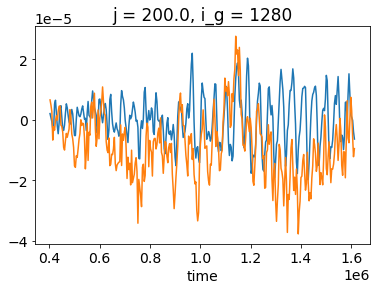

In [229]:
dudt.isel(i_g=200,j=200).plot()
(detadx+fv).isel(i_g=200,j=200).plot()
#fv.isel(i_g=200,j=200).plot()

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/xarray/plot/plot.py:304: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  primitive = ax.plot(xplt_val, yplt_val, *args, **kwargs)
/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/xarray/plot/plot.py:304: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  primitive = ax.plot(xplt_val, yplt_val, *args, **kwargs)


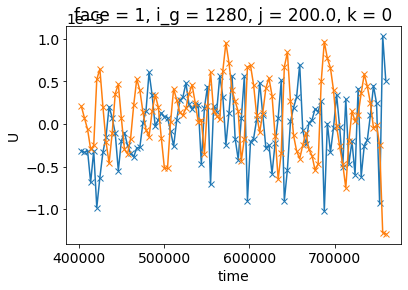

In [221]:
detadx.isel(i_g=200,j=200).isel(time=slice(0,100)).plot(Marker='x')
dudt.isel(i_g=200,j=200).isel(time=slice(0,100)).plot(Marker='x')

[########################################] | 100% Completed | 13min  5.9s
[########################################] | 100% Completed | 16min 25.2s
[########################################] | 100% Completed |  2min 38.4s
[########################################] | 100% Completed |  3min  7.7s
[######                                  ] | 15% Completed |  3min 34.3s

/home/spencerj/.conda/envs/pangeo1/lib/python3.9/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


[########################################] | 100% Completed | 18min 49.3s


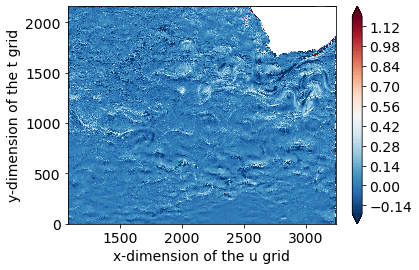

In [172]:
with ProgressBar():
    uadv_cov = (xr.cov((uu_term+uv_term),fv,'time'
      )/xr.cov(fv,fv,'time')).compute()
    
uadv_cov.plot(levels=np.arange(-0.2,1.2,0.01))

In [170]:
(xr.cov((uu_term+uv_term).isel(time=slice(0,33)),fv.isel(time=slice(0,33)),'time')

(<xarray.DataArray ()>
 dask.array<truediv, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>,
 'time')